In [24]:
from itertools import chain, combinations
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV 

In [25]:
%matplotlib inline

In [26]:
PROJECT_FOLDER_PATH = pathlib.Path().resolve().parent#'C:/Users/Arenter/Documents/Python Scripts/rent/Avito'
EDA_DF_PATH = PROJECT_FOLDER_PATH / 'data/interim/eda_df.csv'

In [27]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
df = pd.read_csv(EDA_DF_PATH, index_col=0, parse_dates=['parsing_date', 'pub_date', 'pub_time'])
df = df[(df['pub_date'] >= pd.to_datetime('2020-08-01')) & (df['parsing_date'] != '2020-08-12')]
df = df[df['y'] < 4]

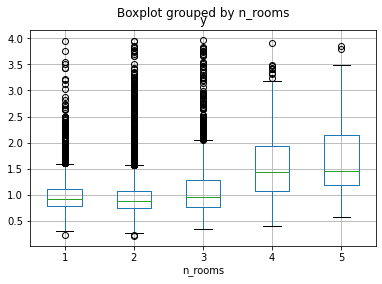

In [30]:
df.boxplot('y', by='n_rooms')

In [31]:
df['first_floor'] = (df['floor'] == 1).astype(int)
df['last_floor'] = (df['floor'] == df['n_floors']).astype(int)

df.drop(columns=['commission_percent', 'pub_date', 'pub_time', 'n_days', 'n_floors', 'rent'], inplace=True)

In [32]:
df_cv = df[df['parsing_date'] < pd.to_datetime('2020-08-13')].drop(columns='parsing_date')
df_eval = df[df['parsing_date'] >= pd.to_datetime('2020-08-13')].drop(columns='parsing_date')
df.columns

Index(['station_distance', 'studio', 'n_rooms', 'area', 'floor', 'mcc',
       'circle', 'center_distance', 'parsing_date', 'y', 'first_floor',
       'last_floor'],
      dtype='object')

In [33]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scores = {'subset': [],
          'model_cv': [],
          'holdout': []
          }
floor_features = ['first_floor', 'last_floor', 'floor']
regular_features = list(set(df_cv.columns) - set(floor_features + ['y']))
rf = RandomForestRegressor(n_estimators=500, n_jobs=2, random_state=1)
for floor_features_subset in list(powerset(floor_features)):
    X_cv, y_cv = df_cv[regular_features + list(floor_features_subset)], df_cv['y']
    X_eval, y_eval = df_eval[regular_features + list(floor_features_subset)], df_eval['y']
    params_space = {
                    'criterion': ['mse', 'mae'],
                    'min_samples_leaf': [1, 5, 10, 20, 50, 70, 100]
                    }
    opt = GridSearchCV(rf, params_space, scoring=mape_scorer, cv=4,
                        n_jobs=-1, return_train_score=True)
    opt.fit(X_cv, y_cv)
    scores['subset'].append(floor_features_subset)
    scores['model_cv'].append(opt)
    scores['holdout'].append(mean_absolute_percentage_error(y_eval, opt.predict(X_eval)))

In [35]:
scores

{'subset': [('first_floor',),
  ('last_floor',),
  ('floor',),
  ('first_floor', 'last_floor'),
  ('first_floor', 'floor'),
  ('last_floor', 'floor'),
  ('first_floor', 'last_floor', 'floor')],
 'model_cv': [GridSearchCV(cv=4,
               estimator=RandomForestRegressor(n_estimators=500, n_jobs=2,
                                               random_state=1),
               n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'min_samples_leaf': [1, 5, 10, 20, 50, 70, 100]},
               return_train_score=True,
               scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)),
  GridSearchCV(cv=4,
               estimator=RandomForestRegressor(n_estimators=500, n_jobs=2,
                                               random_state=1),
               n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'min_samples_leaf': [1, 5, 10, 20, 50, 70, 100]},
               return_

In [36]:
len(scores['holdout'])

7